# 文脈付きバンディット

参考: [Bandit Algorithms](https://tor-lattimore.com/downloads/book/book.pdf)

基本的なバンディット問題では何の事前情報も想定していませんが、現実問題では様々な事前情報が得られます。
線形バンディットや文脈付きバンディットではアームやバンディット自体に情報がついている状況を想定します。

特に敵対的な文脈付きバンディットでは、次のような流れでアルゴリズムが進んでいきます：

---
1. 敵対者が$\left\{1, \dots, n\right\}$間の報酬を選択します：$(x_t)^n_{t=1}$ with $x_t \in [0, 1]^k$
2. 敵対者が$\left\{1, \dots, n\right\}$間の文脈を選択します：$(c_t)^n_{t=1}$ with $c_t \in C$

続いて、時刻 $t=1, \dots, n$で

1. 学習者が文脈 $c_t \in C$を観測します 
2. 学習者が行動の選択肢としてあり得る分布 $P_t \in \mathcal{P}_{k-1}$を選択し、行動$A_t$を$P_t$からサンプルします。
3. 報酬 $X_t = x_{tA_t}$ を観測します。

---

ここでの「文脈」はRLでの「状態」に相当します。状態の数＞１＆ホライゾン＝１なら文脈付きバンディットと同じです。
このとき、次のようなリグレットが自然に考えられます:

$$R_n = E\left[\sum_{c \in C} \max_{i \in [k]} \sum_{t \in [n]: c_t=c} (x_{ti} - X_t)\right]$$

これはつまり、「文脈に依存した最も良い方策」に対する「実行した方策」のリグレットです。RLでもほぼ同じですね。
* ここで、$x_{ti}$と$X_t$はどちらも「文脈が$c$で条件付けられた時刻$t$」であることに注意してください。そのため、異なる文脈では最適なアームが異なるかもしれません。例えば、$c_1$では最適なアームは$1$でも、$c_4$では$2$かもしれません。
* また、全体での実行ステップ数は$n$であることにも注意してください。$Cn$ではありません。

たとえば文脈が何の情報も持ってない場合を考えてみましょう。そして
$$R_{nc} = E\left[\max_{i \in [k]} \sum_{t \in [n]: c_t=c} (x_{ti} - X_t)\right]$$
を文脈が$c$のときのリグレットとします。EXP3アルゴリズム ([bandit_algorithms.ipynb](bandit_algorithms.ipynb)参照)をそれぞれの文脈で走らせた場合、リグレットの上界は

$$
R_{n c} \leq 2 \sqrt{k \sum_{t=1}^n \mathbb{I}\left\{c_t=c\right\} \log (k)}
$$

になります。よって$R_{n} \leq 2 \sqrt{nk|C|\log (k)}$です。これは文脈の数が非常に大きい場合に全然ダメです。もっと効率よく解けないでしょうか？

現実世界では文脈同士になんの構造もないことはまれです。そこで、リグレット$R_n$を等価な別の形式で書き換えてみます。

$$
R_n=\mathbb{E}\left[\max _{\phi \in \Phi} \sum_{t=1}^n\left(x_{t \phi\left(c_t\right)}-X_t\right)\right] .
$$

ここで、$\Phi$は$C \to [k]$な関数の集合です。$\Phi = $k^C$のとき、これは元の形のリグレットと同じです。$\Phi$のサイズが小さい時は探索空間が小さくなるので、より良いリグレットバウンドが期待できます。
$\Phi$での書き換えを踏まえた上で、文脈付き敵対的バンディットを実装するとこんな感じですね：

```python
X_n = adversary_reward(learner)
assert X_n.shape == (n, k)
C_n = adversary_context(learner)
assert len(C_n) == n

pseudo_regret = 0
for t in range(n):
    c_t = C_n[t]
    P = learner.choose_P(c_t)
    a_t = P.sample()
    X_t = X_n[t, a_t]
    pseudo_regret = X_n[t, optimal_phi(c_t)] - X_t
```

まず、一番基本であるエキスパートアドバイス付きバンディットを見てみましょう。


## エキスパートアドバイス付きバンディット

この設定では$M$人のバンディットを解くエキスパートを考え、$M$人のなかから一番良いエキスパートを選択することを考えます。
エキスパート$(i) \in [M]$は時刻$t$で文脈$c_t$を受取り、それぞれのアームの引くべき確率を返します。
つまり、敵対者が選択した時刻$t$での文脈はエキスパートの動作に吸収されるので、実装するとこんな感じになります：

```python
X_n = adversary_reward(learner)
assert X_n.shape == (n, k)
E_n = expert_advice(learner)
assert E_n.shape == (n, M, k)

pseudo_regret = 0
for t in range(n):
    P = learner.choose_P()
    e_t = P.sample()
    expert = E_n[t, e_t]  # k
    a_t = expert.sample()
    X_t = X_n[t, a_t]

    best_rew = best_expert @ X_n[t] 
    pseudo_regret = best_rew - X_t
```

### Exp4 アルゴリズム

エキスパートアドバイス付きのアルゴリズムの基本がExp4 (exponential weighting for exploration and exploitation with experts) です。

時刻$t =1 \dots n$で、
1. エキスパートのアドバイス$E^{(t)}$を取得
2. サンプリング用の分布を計算$P_{t}=Q_t E^{(t)}$
3. アームを選択($A_t \sim P_t$)し、報酬($X_t=x_{tA_t}$)を観測
4. Loss-based importance-weighted estimatorを推定
$$\hat{X}_{ti} = 1 - \frac{\mathbb{I}\{A_t=i\}}{P_{ti}+\gamma}(1-X_t)$$
5. 報酬の情報をエキスパートに反映させるやつ
$$\tilde{X}_{t} = E^{t} \hat{X}_t$$
6. エキスパートの分布を更新
$$Q_{t+1, i}=\frac{\exp(\eta\tilde{X}_{ti})Q_{ti}}{\sum^k_{j=1}\exp(\eta\tilde{X}_{tj})Q_{ti}}$$

$\gamma > 0$ のアルゴリズムはExp4-IXと呼ばれます。

$\eta = \sqrt{2\log(M)/(nk))}$のときにExp4のリグレットは$R_n \leq 2 \sqrt{nk\log(M)}$で抑えられます。
これがどう文脈付きバンディットに関係するのでしょうか？

$C \to [k]$なる関数$\phi$について、エキスパート$m$が$\phi$に従って動くとします。
つまり、$E^{(t)}_{m}=[\mathbb{I}\{\phi(c_t) = 0\}, \mathbb{I}\{\phi(c_t) = 1\}, \dots, \mathbb{I}\{\phi(c_t) = k\}]$です。$|\Phi|=k^C$ならば$M=k^C$であり、このとき$R_n \leq \sqrt{2nk|C|\log(k)}$ですし、一般には

$$R_n \leq \sqrt{2nk\log(|\Phi|)}$$

です。つまり、エキスパートとして「あり得る$C \to [k]$の関数全体」を取ってくるとリグレットは全く良くなりませんが、帰納バイアスによってマシな関数を持ってくると、リグレットはだいぶ良くなります。

最後にPythonで実験してみましょう。(何かが間違ってるので正しく動いてないですな。Qが全然更新されてない...)

100%|██████████| 20/20 [01:23<00:00,  4.16s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


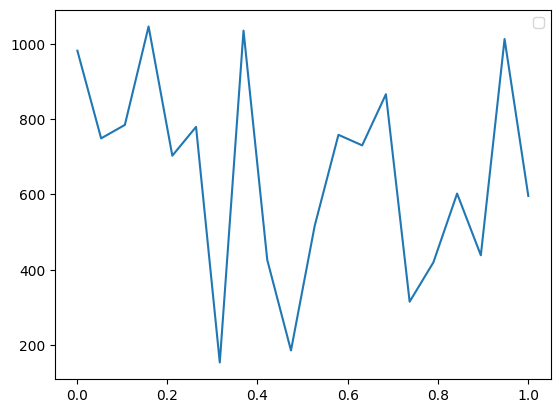

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import special
Array = np.ndarray

# 文脈として複数のBernoulliバンディットを作ります

class BernoulliBandit:
    def __init__(self, rew_mean: Array):
        self.rew_mean = rew_mean
        self.optimal_mean = np.max(self.rew_mean)

    def pull(self, arm: int):
        mean = self.rew_mean[arm]
        reward = np.random.binomial(1, mean)
        return mean, reward


k = 2
C = 2
n_step = 20000
M = 3

def EXP4(lr, seeds=10):
    # コンテキストごとに異なるバンディットを割り当てます
    bandits = [BernoulliBandit(np.array([0.5, 0.5 + np.random.uniform(-0.2, 0.2)])) for c in range(C)]

    experts = []
    # expert 0はほぼ最適なエキスパートとします
    expert0 = []
    for c in range(C):
        rew_mean = bandits[c].rew_mean
        expert0.append([rew_mean[0] > rew_mean[1], rew_mean[0] <= rew_mean[1]])
        # expert0.append(special.softmax(rew_mean))
    experts.append(expert0)

    # 他のエキスパートはランダムに作ります
    for m in range(M-1):
        experts.append([special.softmax(np.random.randn(2)) for c in range(C)])
    E = np.array(experts)    

    assert E.shape == (M, C, k)

    regrets = []
    for _ in range(seeds):
        Q = np.ones(M) / M
        assert Q.shape == (M,)

        pseudo_regret = 0
        for t in range(n_step):
            # コンテキストが発生
            c_t = np.random.randint(C)
            bandit = bandits[c_t]
            experts = E[:, c_t, :]

            # エキスパートの選択
            P = (Q.reshape(M, 1) * experts).sum(axis=0)
            act = np.random.choice(k, p=P)
            prob = P[act]
            mean, rew = bandit.pull(act)
            X_hat = np.ones(k)
            X_hat[act] = 1 - (1 - rew) / prob

            # Qの更新
            Q = np.exp(lr * experts @ X_hat) * Q
            Q = special.softmax(Q)

            # 結果の記録
            pseudo_regret += bandit.optimal_mean - mean
        
        regrets.append(pseudo_regret)
    return np.mean(regrets)

lrs = np.linspace(0.001, 1.0, 20)
regrets = []
for lr in tqdm(lrs):
    regrets.append(EXP4(lr, seeds=10))

plt.plot(lrs, regrets)
plt.legend()